In [1]:
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import matplotlib.font_manager
from sklearn import svm
import datetime
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score


In [3]:
def load_data(path, rows = 300000):
    """
    Load the training data
    rows --> maximum number of rows to load from the dataset

    """
    data = pd.read_csv(path, header=None, sep=',')
    data = data.drop_duplicates()
    data = data.sample(frac = 1)
    data = data.reset_index(drop=True)
    data = data[:rows]
    data.columns = ['B1', 'C1', 'A2', 'B2', 'C2', 'ma_B1', 'ma_C1', 'ma_A2', 'ma_B2', 'ma_C2']
    
    return data[['B1', 'C1', 'A2', 'B2', 'C2', 'ma_B1', 'ma_C1', 'ma_A2', 'ma_B2', 'ma_C2']]

def load_data_test(path, rows = 25000):
    """
    Load the testing data (HT clean and HT contaminated)
    rows --> maximum number of rows to load from the dataset
    
    """
    data = pd.read_csv(path, header=None, sep=',')
    data = data.sample(frac = 1)
    data = data.reset_index(drop=True)
    data = data[:rows]
#     data.columns = ['1', '2', '3', '4', '5', 'MA_col1', 'MA_col2', 'MA_col3', 'MA_col4', 'MA_col5']
    data.columns = ['B1', 'C1', 'A2', 'B2', 'C2', 'ma_B1', 'ma_C1', 'ma_A2', 'ma_B2', 'ma_C2']
    # data = data.drop_duplicates()
    return data[['B1', 'C1', 'A2', 'B2', 'C2', 'ma_B1', 'ma_C1', 'ma_A2', 'ma_B2', 'ma_C2']]

In [4]:
# Define number of rows to load from the dataset
Number_of_train_rows = 5000 
Number_of_test_rows = 100000  # This is only half of the overall test dataframe, since we append HT-clean to HT-contaminated


# Load the dataframes

# train_file_path  = r'C:\Users\Gor\Desktop\New_experiments\Important_files-3\new_DATA\Split_into_train_test\HT3_3\4\my_training_data.txt'
# test_file_path   = r'C:\Users\Gor\Desktop\New_experiments\Important_files-3\new_DATA\Split_into_train_test\HT3_3\4\my_testing_data.txt'
# trojan_file_path = r'C:\Users\Gor\Desktop\New_experiments\Important_files-3\new_DATA\Split_into_train_test\HT3_3\4\my_trojan_data.txt'

HTname =                                                                                         "a^100"
train_file_path  = r'C:\Users\Gor\Desktop\New_experiments\Important_files-3\DATA\newerrrr_DATA\HT_a^100\my_training_data.txt'
edge_points_path = r'C:\Users\Gor\Desktop\New_experiments\Important_files-3\DATA\newerrrr_DATA\HT_a^100\Edge_points.txt'
test_file_path   = r'C:\Users\Gor\Desktop\New_experiments\Important_files-3\DATA\newerrrr_DATA\HT_a^100\my_testing_data.txt'
trojan_file_path = r'C:\Users\Gor\Desktop\New_experiments\Important_files-3\DATA\newerrrr_DATA\HT_a^100\my_trojan_data.txt'

# Load edge point data
edge_points = load_data(edge_points_path, rows = 100000)
edge_points = np.r_[edge_points]
edge_points_rows, edge_points_columns = edge_points.shape

# Generate train data
train_data = load_data(train_file_path, rows = Number_of_train_rows)
X_train = np.r_[train_data]
X_train = np.vstack((X_train, edge_points))
n_train_rows, n_train_columns = X_train.shape

# Generate some regular novel observations
test_data = load_data_test(test_file_path, rows = Number_of_test_rows)
X_test = np.r_[test_data]
n_test_rows, test_columns = X_test.shape

# Generate some abnormal novel observations
trojan_data = load_data_test(trojan_file_path, rows = Number_of_test_rows)
X_outliers = np.r_[trojan_data]
n_outliers_rows, outliers_columns = X_outliers.shape

### Quick visualisation of the datapoints

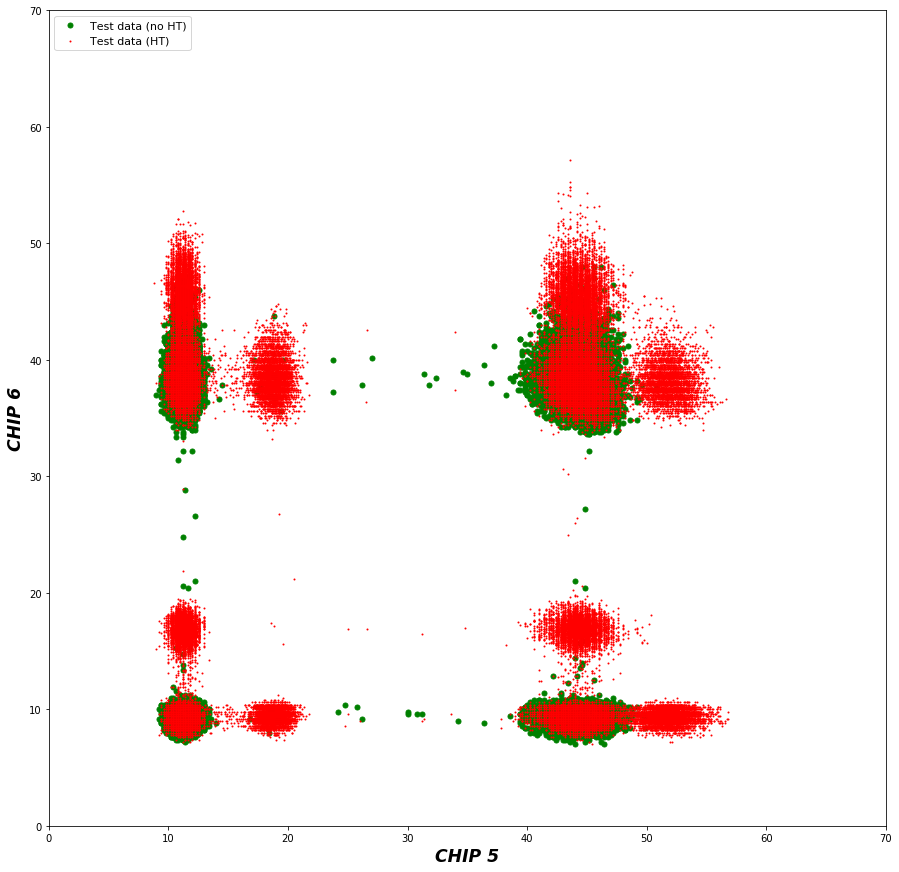

In [5]:
plt.figure(figsize=(15,15))

column1 = 5
column2 = 6

noHT = plt.scatter(X_test[:, column1], X_test[:, column2], c='green', s=25, edgecolors='green')
HT = plt.scatter(X_outliers[:, column1], X_outliers[:, column2], c='red', s=1, edgecolors='red')

plt.axis('tight')
plt.xlim((0, 70))
plt.ylim((0, 70))
# plt.xlim((0, 100))
# plt.ylim((250, 275))

plt.legend([noHT, HT], ["Test data (no HT)", "Test data (HT)"], loc="upper left",
           prop=matplotlib.font_manager.FontProperties(size=11))

# plt.xlabel(
#     "Errors train: %d/%d ; "
#     "Errors novel regular: %d/%d ; "
#     "Errors novel abnormal: %d/%d"
#     % (n_error_train, n_train_rows ,n_error_test, n_test_rows, n_error_outliers, n_outliers_rows))
plt.xlabel("CHIP {}".format(column1), fontsize='xx-large', fontstyle='oblique', fontweight='bold')
plt.ylabel("CHIP {}".format(column2), fontsize='xx-large', fontstyle='oblique', fontweight='bold')

plt.show()

#### Prepare the data

In [6]:
y_train = np.ones((Number_of_train_rows+edge_points_rows,1), dtype='int')
y_test = np.ones((Number_of_test_rows,1), dtype='int')
y_outliers = np.negative(np.ones((Number_of_test_rows,1), dtype='int'))
y_test_comined = np.vstack((y_test,y_outliers))
X_test_comined = np.vstack((X_test,X_outliers))
full_test_data = np.hstack((X_test_comined, y_test_comined))
np.random.shuffle(full_test_data)
y_test_comined = full_test_data[:,-1].reshape(int(Number_of_test_rows*2),1)
X_test_comined = full_test_data[:,0:-1]

print("Test data manipulation...")
print(y_test.shape,'  // HT clean test data label shape')
print(y_outliers.shape,'  // HT contaminated test data label shape')
print(y_test_comined.shape,'  // Combined test data label shape')
print()
print(X_test.shape,'  // HT clean test data feature shape')
print(X_outliers.shape,'  // HT contaminated test data feature shape')
print(full_test_data.shape,'  // Combined test data (feature + label) shape')

Test data manipulation...
(100000, 1)   // HT clean test data label shape
(100000, 1)   // HT contaminated test data label shape
(200000, 1)   // Combined test data label shape

(100000, 10)   // HT clean test data feature shape
(100000, 10)   // HT contaminated test data feature shape
(200000, 11)   // Combined test data (feature + label) shape


### Scaling the data..........update: actually worsened the results

In [7]:
# from sklearn.preprocessing import MinMaxScaler, StandardScaler
# #Scaling
# # Column_names = X.columns
# scaler = MinMaxScaler()
# scaler.fit(X_train)
# X_train =scaler.transform(X_train)
# X_test_comined = scaler.transform(X_test_comined)


# Train the model

In [8]:
# fit the model
# nu = 0.001
# gamma = 0.0035

# nu = 0.025
# gamma = 0.012

nu = 0.001
gamma = 0.009
kernel = "rbf"

clf = svm.OneClassSVM(nu=nu, kernel=kernel, gamma=gamma)
clf.fit(X_train)

y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)
y_pred_outliers = clf.predict(X_outliers)
y_pred_combined = clf.predict(X_test_comined).reshape(-1,1)
num_of_support_vectors = clf.support_vectors_.shape[0]

In [9]:
# TRAIN scores

Precision = precision_score(y_train, y_pred_train)
Recall    = recall_score(y_train, y_pred_train)
F1_score  = f1_score(y_train, y_pred_train)
Accuracy  = accuracy_score(y_train, y_pred_train)

print(nu, gamma)
print(Precision, Recall)
print(F1_score)
print(clf.support_vectors_.shape)

0.001 0.009
1.0 0.9691826708351943
0.9843501927874801
(594, 10)


In [10]:
# TEST scores

Precision = precision_score(y_test_comined, y_pred_combined)
Recall    = recall_score(y_test_comined, y_pred_combined)
F1_score  = f1_score(y_test_comined, y_pred_combined)
Accuracy  = accuracy_score(y_test_comined, y_pred_combined)

print(HTname)
print(nu, gamma)
print(Precision, Recall)
print(F1_score)
print(clf.support_vectors_.shape)

a^100
0.001 0.009
0.8096961163141004 0.98906
0.890435377579315
(594, 10)


In [11]:
print(clf.support_vectors_.shape[0])
print(clf.n_support_)
print(clf.support_vectors_)
print(clf.dual_coef_)

594
[594]
[[ 43.   33.  267.  ... 264.2   9.    7.8]
 [ 10.   11.  261.  ... 264.   28.8   8.6]
 [ 10.    8.  264.  ... 264.2  37.4   9.6]
 ...
 [ 13.   10.  261.  ... 263.8   8.2  26.2]
 [ 44.   34.  265.  ... 266.   33.8  28.6]
 [ 41.   49.  257.  ... 260.6   8.4  34.6]]
[[0.03843811 0.02518298 0.0154573  0.07937932 0.01430557 0.00995527
  0.02381924 0.02319023 0.00711295 0.00714665 0.08098092 0.01041396
  0.09355252 0.02619389 0.00175232 0.01049108 0.0219229  0.04466898
  0.04160154 0.00176164 0.00063938 0.0216638  0.00976112 0.01118732
  0.00616961 0.07993546 0.00106467 0.00686365 0.01155284 0.0985392
  0.10180108 0.03651329 0.02175396 0.02915326 0.00680362 0.05330919
  0.00218694 0.09279572 0.00231102 0.00142652 0.03076264 0.02355021
  0.00075331 0.01123039 0.01873264 0.03521269 0.02293016 0.02845091
  0.01138658 0.01223879 0.00455741 0.00853905 0.01112963 0.049145
  0.01695315 0.00559417 0.03205404 0.04114048 0.0223705  0.05072152
  0.0280702  0.01322447 0.00186257 0.02528753 0.0

In [12]:
np.savetxt('Support_Vectors.txt', clf.support_vectors_*100, fmt='%8.0f', delimiter=',')
np.savetxt('Dual_coefs.txt', (clf.dual_coef_)*10000, fmt='%5.0f', delimiter=',')
np.savetxt('Intercept.txt', clf.intercept_, fmt='%.5f', delimiter=',')

In [13]:
np.sum(clf.dual_coef_)/(nu*Number_of_train_rows)

2.238999999999847

In [14]:
clf.intercept_/(nu*Number_of_train_rows)

array([-0.02072393])

In [15]:
X = np.array([  
[90.40, 84.00, 259.20, 81.60, 84.80, 90.56, 86.40, 262.56, 79.20, 83.84],
[107.20, 78.40, 263.20, 96.80, 100.00, 108.96, 76.16, 262.24, 94.08, 98.24],
[92.00, 84.00, 263.20, 80.00, 73.60, 91.84, 86.56, 261.28, 81.44, 78.88]
])


clf.decision_function(X)

array([-0.10361965, -0.10361965, -0.10361965])

In [16]:
hhh = np.array([
[0.517563,  0.022585],
[0.322728,  0.027974],
[0.267170,  0.017931],
[0.529931,  0.020932],
[0.534120,  0.034464],
[0.463554,  0.034464],
[0.538340,  0.047891],
[0.549761,  0.038789],
[0.278625,  0.034464],
[0.593228,  0.002908],
[0.309460,  0.058661],
[0.399157,  0.034464],
[0.295183,  0.036237],
[0.545450,  0.034464],
[0.465993,  0.030600],
[0.282305,  0.028485],
[0.494983,  0.004131],
[0.521653,  0.031804]])
sum(hhh[:, 0]*hhh[:, 1])

0.23175907610700003

In [17]:
euc = np.array([
160.64,
275.84,
321.92,
154.88,
152.96,
187.52,
151.04,
145.92,
311.68,
127.36,
286.08,
224.00,
297.60,
147.84,
186.24,
308.48,
171.52,
158.72])

alf = np.array([
0.022585,
0.027974,
0.017931,
0.020932,
0.034464,
0.034464,
0.047891,
0.038789,
0.034464,
0.002908,
0.058661,
0.034464,
0.036237,
0.034464,
0.030600,
0.028485,
0.004131,
0.031804    
])

gamma = 0.0041
np.sqrt(euc)

array([12.67438361, 16.60843159, 17.94212919, 12.44507935, 12.36769987,
       13.69379421, 12.2898332 , 12.0797351 , 17.65446119, 11.28538878,
       16.91389961, 14.96662955, 17.25108692, 12.15894732, 13.64697769,
       17.56359872, 13.09656443, 12.5984126 ])